In [101]:
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3 import PPO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [102]:
checkpoint_callback = CheckpointCallback(save_freq=1e4, save_path='./model_checkpoints/')

In [103]:
df = pd.read_csv("hackathon_sample_v2.csv")
df

,date,ret_eom,permno,shrcd,exchcd,mspread,year,month,size_port,rf,...,betadown_252d,bidaskhl_21d,corr_1260d,betabab_1260d,rmax5_rvol_21d,age,qmj,qmj_prof,qmj_growth,qmj_safety
0,20000131,20000131,10078,11,3,0.017178,2000,1,B,0.0041,...,2.219037,0.012635,0.504688,1.581540,1.373224,180,1.700939,1.711756,1.476410,1.087626
1,20000131,20000131,10104,11,3,0.019720,2000,1,B,0.0041,...,1.437330,0.016634,0.473872,1.941648,2.058353,180,0.828930,1.717670,-0.603531,0.608215
2,20000131,20000131,10107,11,3,0.011369,2000,1,B,0.0041,...,1.466883,0.003855,0.563178,1.228124,1.899772,180,1.190962,1.682187,-0.583515,1.336684
3,20000131,20000131,10108,11,1,0.010600,2000,1,B,0.0041,...,-0.285524,0.015658,0.327841,0.952188,1.187073,180,1.332815,1.453165,0.210170,1.130917
4,20000131,20000131,10119,11,1,0.003485,2000,1,B,0.0041,...,0.217867,0.004411,0.289368,0.457370,0.715285,228,0.785417,-0.381167,1.689625,0.331900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273368,20231229,20231231,93330,11,1,0.004891,2023,12,B,0.0043,...,0.946309,0.003779,0.720817,1.241060,1.464466,887,0.683460,0.169549,0.627055,0.745462
273369,20231229,20231231,93356,11,3,0.004867,2023,12,B,0.0043,...,1.481037,0.007985,0.642513,1.388323,1.578243,227,1.679546,1.550166,0.993086,1.619852
273370,20231229,20231231,93369,11,3,0.018935,2023,12,B,0.0043,...,1.239248,0.012130,0.454100,1.339266,1.407091,191,-0.039003,-0.435984,1.397522,-0.570584
273371,20231229,20231231,93374,11,1,0.004107,2023,12,B,0.0043,...,0.870553,0.003574,0.653959,1.200649,1.754520,227,-0.801070,-0.632446,-0.982286,0.687467


<Axes: >

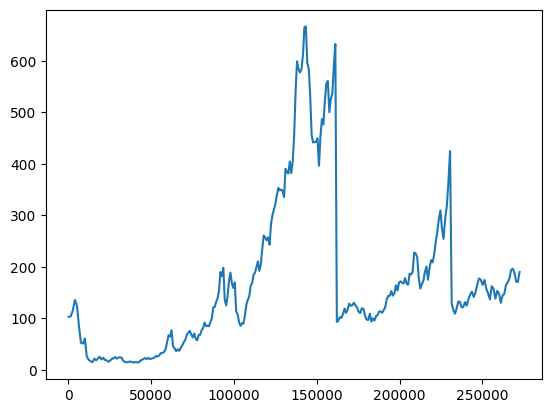

In [104]:
df[df['stock_ticker'] == 'AAPL']['prc'].plot()

In [105]:
df = df.fillna(0)

In [106]:
def personal_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size
    end = frame_bound[1]
    prices = df.loc[:, 'prc'].to_numpy()[start:end]
    signal_features = df.loc[:, [
        'age', 'aliq_at', 'aliq_mat', 'ami_126d', 'at_be', 'at_gr1', 'at_me', 'at_turnover', 'be_gr1a', 'be_me', 'beta_60m', 'beta_dimson_21d', 'betabab_1260d', 'betadown_252d', 'bev_mev', 'bidaskhl_21d', 'capex_abn', 'capx_gr1', 'capx_gr2', 'capx_gr3', 'cash_at', 'chcsho_12m', 'coa_gr1a', 'col_gr1a', 'cop_at', 'cop_atl1', 'corr_1260d', 'coskew_21d', 'cowc_gr1a', 'dbnetis_at', 'debt_gr3', 'debt_me', 'dgp_dsale', 'div12m_me', 'dolvol_126d', 'dolvol_var_126d', 'dsale_dinv', 'dsale_drec', 'dsale_dsga', 'earnings_variability', 'ebit_bev', 'ebit_sale', 'ebitda_mev', 'emp_gr1', 'eq_dur', 'eqnetis_at', 'eqnpo_12m', 'eqnpo_me', 'eqpo_me', 'f_score', 'fcf_me', 'fnl_gr1a', 'gp_at', 'gp_atl1', 'intrinsic_value', 'inv_gr1', 'inv_gr1a', 'iskew_capm_21d', 'iskew_ff3_21d', 'iskew_hxz4_21d', 'ivol_capm_21d', 'ivol_capm_252d', 'ivol_ff3_21d', 'ivol_hxz4_21d', 'kz_index', 'lnoa_gr1a', 'lti_gr1a', 'market_equity', 'mispricing_mgmt', 'mispricing_perf', 'ncoa_gr1a', 'ncol_gr1a', 'netdebt_me', 'netis_at', 'nfna_gr1a', 'ni_ar1', 'ni_be', 'ni_inc8q', 'ni_ivol', 'ni_me', 'niq_at', 'niq_at_chg1', 'niq_be', 'niq_be_chg1', 'niq_su', 'nncoa_gr1a', 'noa_at', 'noa_gr1a', 'o_score', 'oaccruals_at', 'oaccruals_ni', 'ocf_at', 'ocf_at_chg1', 'ocf_me', 'ocfq_saleq_std', 'op_at', 'op_atl1', 'ope_be', 'ope_bel1', 'opex_at', 'pi_nix', 'ppeinv_gr1a', 'prc', 'prc_highprc_252d', 'qmj', 'qmj_growth', 'qmj_prof', 'qmj_safety', 'rd_me', 'rd_sale', 'rd5_at', 'resff3_12_1', 'resff3_6_1', 'ret_1_0', 'ret_12_1', 'ret_12_7', 'ret_3_1', 'ret_6_1', 'ret_60_12', 'ret_9_1', 'rmax1_21d', 'rmax5_21d', 'rmax5_rvol_21d', 'rskew_21d', 'rvol_21d', 'sale_bev', 'sale_emp_gr1', 'sale_gr1', 'sale_gr3', 'sale_me', 'saleq_gr1', 'saleq_su', 'seas_1_1an', 'seas_1_1na', 'seas_2_5an', 'seas_2_5na', 'sti_gr1a', 'taccruals_at', 'taccruals_ni', 'tangibility', 'tax_gr1a', 'turnover_126d', 'turnover_var_126d', 'z_score', 'zero_trades_126d', 'zero_trades_21d', 'zero_trades_252d'
    ]].to_numpy()[start:end]
    return prices, signal_features


class PersonalStocksEnv(StocksEnv):
    
    def __init__(self, prices, signal_features, **kwargs):
        self._prices = prices
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._prices, self._signal_features


In [107]:
prices, signal_features = personal_process_data(df=df, window_size=30, frame_bound=(30, len(df)))
env = PersonalStocksEnv(prices, signal_features, df=df, window_size=30, frame_bound=(30, len(df)))

In [108]:
model = PPO('MlpPolicy', env, tensorboard_log="./logs/progress_tensorboard/", verbose=1) 
model.learn(total_timesteps=1_000_000_000, callback=[checkpoint_callback])

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/progress_tensorboard/PPO_5
-----------------------------
| time/              |      |
|    fps             | 4264 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 2444         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0049118297 |
|    clip_fraction        | 0.00723      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.691       |
|    explained_variance   | -0.00027     |
|    learning_rate        | 0.0003       |
|    loss                 | 4.15e+03     |
|    n_updates            | 10           |
|    p

/Users/sargunsinghbhatti/Documents/Documents - Sargun’s MacBook Air/GitHub/PPO-for-Beginners/venv/lib/python3.10/site-packages/gym_anytrading/envs/stocks_env.py:62: RuntimeWarning: overflow encountered in scalar multiply
  self._total_profit = (shares * (1 - self.trade_fee_bid_percent)) * current_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 2.73e+05      |
|    ep_rew_mean          | 1.75e+06      |
| time/                   |               |
|    fps                  | 1727          |
|    iterations           | 497           |
|    time_elapsed         | 589           |
|    total_timesteps      | 1017856       |
| train/                  |               |
|    approx_kl            | 1.7605431e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.216        |
|    explained_variance   | 6.68e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 2e+07         |
|    n_updates            | 4960          |
|    policy_gradient_loss | -9.76e-05     |
|    value_loss           | 5.2e+08       |
-------------------------------------------
------------------------------------------
| rollout/                |      

info {'total_reward': 75.42493438400004, 'total_profit': 1.0645761659631199, 'position': <Positions.Short: 0>}


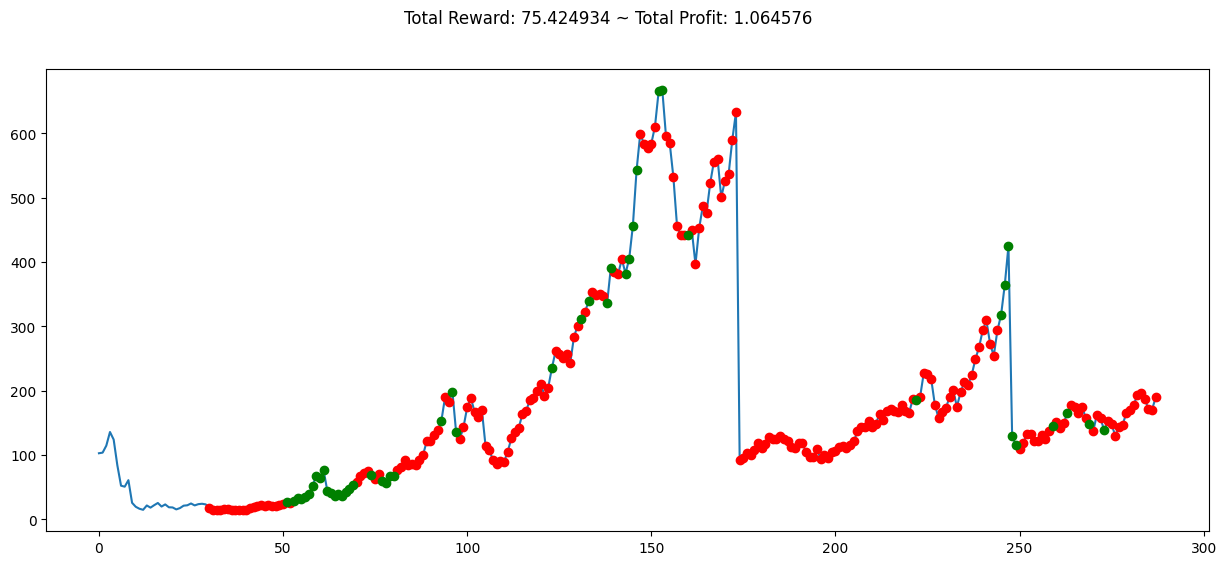

In [100]:
prices, signal_features = personal_process_data(df=df[df['stock_ticker'] == 'AAPL'], window_size=30, frame_bound=(30, len(df[df['stock_ticker'] == 'AAPL'])))
env = PersonalStocksEnv(prices, signal_features, df=df[df['stock_ticker'] == 'AAPL'], window_size=30, frame_bound=(30, len(df[df['stock_ticker'] == 'AAPL'])))


obs, _ = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print("info", info)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()